In [51]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

warnings.filterwarnings('ignore', 'SelectableGroups dict interface')
#I think this is a problem with spacy? maybe sub lib out with different lemmatizer

In [3]:
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


In [4]:
df.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [5]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

<>:5: DeprecationWarning: invalid escape sequence '\S'
<>:8: DeprecationWarning: invalid escape sequence '\s'
<>:5: DeprecationWarning: invalid escape sequence '\S'
<>:8: DeprecationWarning: invalid escape sequence '\s'
C:\Users\lachl\AppData\Local\Temp\ipykernel_24108\1560797528.py:5: DeprecationWarning: invalid escape sequence '\S'
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
C:\Users\lachl\AppData\Local\Temp\ipykernel_24108\1560797528.py:8: DeprecationWarning: invalid escape sequence '\s'
  data = [re.sub('\s+', ' ', sent) for sent in data]


['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations


In [8]:
data_words = list(sent_to_words(data))

In [9]:
data_words[:1]

[['from',
  'wheres',
  'my',
  'thing',
  'subject',
  'what',
  'car',
  'is',
  'this',
  'nntp',
  'posting',
  'host',
  'rac',
  'wam',
  'umd',
  'edu',
  'organization',
  'university',
  'of',
  'maryland',
  'college',
  'park',
  'lines',
  'was',
  'wondering',
  'if',
  'anyone',
  'out',
  'there',
  'could',
  'enlighten',
  'me',
  'on',
  'this',
  'car',
  'saw',
  'the',
  'other',
  'day',
  'it',
  'was',
  'door',
  'sports',
  'car',
  'looked',
  'to',
  'be',
  'from',
  'the',
  'late',
  'early',
  'it',
  'was',
  'called',
  'bricklin',
  'the',
  'doors',
  'were',
  'really',
  'small',
  'in',
  'addition',
  'the',
  'front',
  'bumper',
  'was',
  'separate',
  'from',
  'the',
  'rest',
  'of',
  'the',
  'body',
  'this',
  'is',
  'all',
  'know',
  'if',
  'anyone',
  'can',
  'tellme',
  'model',
  'name',
  'engine',
  'specs',
  'years',
  'of',
  'production',
  'where',
  'this',
  'car',
  'is',
  'made',
  'history',
  'or',
  'whatever',
  

In [10]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [12]:
#This one takes a loooooong time 
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

C:\Users\lachl\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\lachl\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\lachl\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\lachl\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POIN

C:\Users\lachl\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\lachl\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\lachl\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\lachl\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POIN

C:\Users\lachl\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\lachl\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\lachl\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\lachl\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POIN

['s thing subject car nntp post host rac college park line wonder out there enlighten car see other day door sport car look late early call door really small addition front bumper separate rest body know tellme model name engine spec year production car make history info funky look car mail thank bring neighborhood lerxst', 'subject clock poll final call summary final call si clock report keyword si acceleration clock upgrade article shelley innc organization line nntp post host fair number brave soul upgrade si clock oscillator share experience poll send brief message detail experience procedure top speed attain cpu rate speed add card adapter heat sink hour usage day floppy disk functionality floppy especially request summarize next day so add network knowledge base do clock upgrade answer poll thank']


In [13]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )
data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [ ]:
#this takes a long time 
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)

In [16]:
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -8296695.418199853
Perplexity:  1779.5247310330933
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [18]:
#Big job, looooooooong time 

search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 15, 20, 25, 30]})

In [19]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -1743776.9238999425
Model Perplexity:  1696.9124485645912


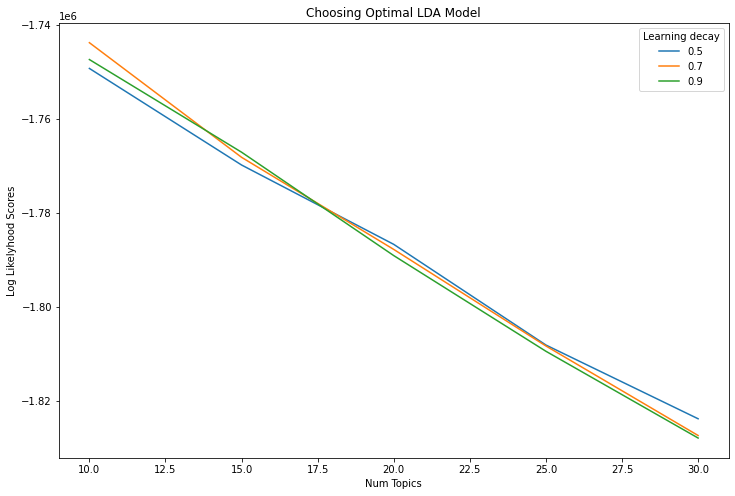

In [37]:
# Get Log Likelyhoods from Grid Search Output
#this is a little schizo at the moment, dunno exaclty how to fix it. 
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = \
[round(model.cv_results_['mean_test_score'][gscore]) 
                     for gscore in range(len(model.cv_results_['mean_test_score'])) 
 if model.cv_results_['params'][gscore]['learning_decay']==0.5]
log_likelyhoods_7 = \
[round(model.cv_results_['mean_test_score'][gscore]) 
                     for gscore in range(len(model.cv_results_['mean_test_score'])) 
 if model.cv_results_['params'][gscore]['learning_decay']==0.7]
log_likelyhoods_9 = \
[round(model.cv_results_['mean_test_score'][gscore]) 
                     for gscore in range(len(model.cv_results_['mean_test_score'])) 
 if model.cv_results_['params'][gscore]['learning_decay']==0.9]
# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [24]:
model.cv_results_

{'mean_fit_time': array([55.62152939, 41.65108142, 44.52610393, 48.28572683, 64.57379894,
        43.12331305, 63.09495797, 52.60334101, 72.89762321, 70.64344635,
        62.26971445, 46.07677212, 45.01968045, 49.7003449 , 52.76609616]),
 'std_fit_time': array([15.64426546,  1.65967986,  0.7157818 ,  0.4010804 , 18.3215567 ,
         4.8483558 ,  1.36239623, 11.36042796,  6.84309213, 12.24550312,
         1.93426737, 10.12277868,  0.8210444 ,  0.87232457,  0.99952776]),
 'mean_score_time': array([0.99256687, 0.83632488, 0.98206186, 1.00959697, 1.23233294,
        0.89571867, 1.26765552, 1.07121701, 1.4764771 , 1.39017644,
        1.17738352, 0.85374756, 0.95086846, 1.04748816, 1.11735797]),
 'std_score_time': array([0.28861559, 0.05890898, 0.05549244, 0.01635686, 0.27313988,
        0.16948612, 0.06732368, 0.27621552, 0.06934135, 0.36421499,
        0.05933232, 0.18139108, 0.05054714, 0.06627425, 0.04677996]),
 'param_learning_decay': masked_array(data=[0.5, 0.5, 0.5, 0.5, 0.5, 0.7, 0.

In [27]:
model.best_score_

-1743776.9238999425

In [39]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.200000,0.290000,0.000000,3
Doc1,0.110000,0.000000,0.000000,0.000000,0.000000,0.050000,0.430000,0.290000,0.000000,0.120000,6
Doc2,0.100000,0.000000,0.000000,0.150000,0.060000,0.090000,0.050000,0.320000,0.210000,0.000000,7
Doc3,0.000000,0.000000,0.000000,0.360000,0.000000,0.080000,0.090000,0.450000,0.000000,0.000000,7
Doc4,0.000000,0.420000,0.000000,0.170000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,1
Doc5,0.000000,0.000000,0.000000,0.840000,0.000000,0.000000,0.000000,0.000000,0.000000,0.150000,3
Doc6,0.000000,0.000000,0.000000,0.170000,0.000000,0.230000,0.000000,0.580000,0.000000,0.000000,7
Doc7,0.000000,0.000000,0.000000,0.000000,0.110000,0.060000,0.660000,0.170000,0.000000,0.000000,6
Doc8,0.010000,0.010000,0.010000,0.010000,0.010000,0.950000,0.010000,0.010000,0.010000,0.010000,5
Doc9,0.150000,0.000000,0.000000,0.000000,0.000000,0.350000,0.490000,0.000000,0.000000,0.000000,6


In [40]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,3,1657
1,5,1634
2,7,1605
3,6,1348
4,8,1123
5,0,1053
6,4,1042
7,2,798
8,1,786
9,9,268


In [41]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\lachl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\lachl\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
C:\Users\lachl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\lachl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
3      32.420952   8.115230       1        1  13.058390
5       0.648955  71.707100       2        1  12.877037
2      71.019684   9.971006       3        1  12.100700
4       3.785981  33.185135       4        1  11.648321
8     -42.666500  -9.222070       5        1   9.422275
6      -3.621689 -43.526516       6        1   9.310084
1      -3.632402  -4.171708       7        1   9.046893
7     -36.584400  35.804413       8        1   7.995671
9      44.391380  50.615383       9        1   7.380114
0      40.235809 -31.591665      10        1   7.160515, topic_info=      Term         Freq        Total Category  logprob  loglift
5383  post  6891.000000  6891.000000  Default  30.0000  30.0000
3373  host  4942.000000  4942.000000  Default  29.0000  29.0000
2963  game  1868.000000  1868.000000  Default  28.0000  28.0000
4746  nntp  4319.000000  4319.000000  Default  27.0000  27.0000
2738  file  3006.000000  3006.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
3878  just   433.073249  5556.884814  Topic10  -5.2111   0.0847
5383  post   448.654165  6891.840771  Topic10  -5.1757  -0.0953
1324  come   355.601816  3307.407583  Topic10  -5.4082   0.4065
3373  host   362.207009  4942.839327  Topic10  -5.3898   0.0231
3932  know   340.416184  6562.829948  Topic10  -5.4518  -0.3224

[821 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
34        1  0.033226   accept
34        2  0.081071   accept
34        3  0.146194   accept
34        4  0.524969   accept
34        5  0.047845   accept
...     ...       ...      ...
7956      8  0.028032     year
7956      9  0.087183     year
7956     10  0.278780     year
7958      7  0.989687    yeast
7975      7  0.990990  zoology

[2503 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 3, 5, 9, 7, 2, 8, 10, 1])

In [43]:
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names_out()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aaa,abandon,abbreviation,aberystwyth,abide,ability,able,abolish,abomination,abort,...,yourselfer,youth,zaphod,zinc,zionism,zionist,zip,zone,zoology,zoom
Topic0,60.848331,0.100015,3.628566,0.100000,0.100000,44.670625,59.063613,0.100000,0.100000,0.100001,...,0.100000,1.954628,0.100018,9.504750,0.100000,0.100000,0.100003,78.419995,0.100001,0.901347
Topic1,0.119788,2.987855,1.671521,0.100001,0.100001,68.835539,104.550497,0.100002,0.100000,16.780149,...,0.100014,0.100054,7.959635,5.017258,0.100000,0.100001,0.100039,0.100007,83.099668,0.100003
Topic2,0.100003,22.208130,0.100001,0.100000,4.987083,6.994619,125.618587,5.004927,3.121898,0.100035,...,0.100021,25.480799,0.100017,0.100000,68.900215,71.099980,0.100016,65.417189,0.100001,0.100001
Topic3,0.100031,3.480299,0.100005,11.648586,50.003781,39.990618,104.264891,0.100021,12.387878,7.409291,...,3.099903,13.714994,5.118752,1.518621,0.299762,0.100004,19.355452,5.452128,0.100002,0.100004
Topic4,0.100001,23.787432,0.100004,0.100000,0.100051,37.360647,70.124087,25.814344,1.790208,1.153062,...,0.100041,0.100011,0.100055,0.100000,0.100004,0.100010,1.225936,0.100006,0.100000,0.100012


In [45]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,game,team,play,year,line,win,player,good,write,subject,think,season,article,hockey,time
Topic 1,space,write,say,science,year,time,think,use,make,know,article,people,launch,line,study
Topic 2,say,people,armenian,know,government,come,write,right,turkish,kill,israeli,think,time,war,tell
Topic 3,write,article,line,gun,just,subject,car,think,make,people,use,post,say,good,time
Topic 4,say,people,believe,christian,write,think,make,know,question,line,subject,just,thing,good,religion
Topic 5,use,window,file,line,program,subject,image,run,write,version,problem,software,graphic,available,color
Topic 6,use,key,drive,chip,card,line,bit,disk,write,encryption,subject,work,clipper,scsi,need
Topic 7,line,post,subject,host,nntp,write,article,organization,reply,know,thank,distribution,computer,world,help
Topic 8,line,new,good,sale,work,subject,price,make,year,sell,buy,want,know,cost,think
Topic 9,file,use,law,public,information,entry,number,right,state,people,issue,case,group,program,line


In [52]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores



In [53]:
# Predict the topic
mytext = ["I want to buy a new bike but the price isnt good at the moment"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)

['line', 'new', 'good', 'sale', 'work', 'subject', 'price', 'make', 'year', 'sell', 'buy', 'want', 'know', 'cost', 'think']


In [54]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.16  0.14  0.13  0.44  0.16  0.5   0.28  0.55  0.28  0.08]
 [ 0.08  0.04  0.12  0.71  0.08 -0.67 -0.11 -0.04  0.08  0.03]]
Perc of Variance Explained: 
 [0.03 0.19]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

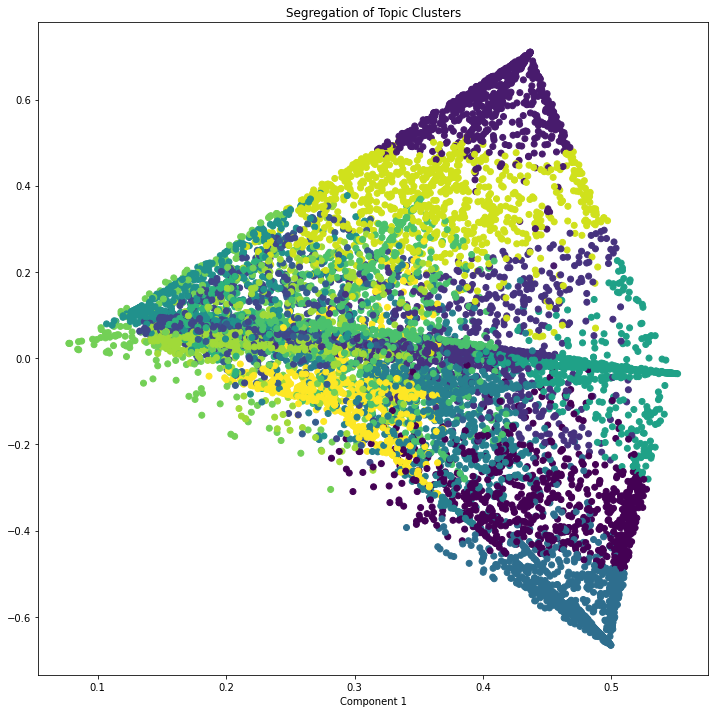

In [56]:
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [57]:
from sklearn.metrics.pairwise import euclidean_distances

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = data, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [58]:
mytext = ["Some text about christianity and bible"]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)
print('\n', docs[0][:500])

Topic KeyWords:  ['say', 'people', 'believe', 'christian', 'write', 'think', 'make', 'know', 'question', 'line', 'subject', 'just', 'thing', 'good', 'religion']
Topic Prob Scores of text:  [[0.  0.  0.  0.  0.7 0.  0.  0.  0.  0. ]]
Most Similar Doc's Probs:   [[0.  0.1 0.1 0.  0.7 0.  0.  0.  0.  0.1]]


MemoryError: Unable to allocate 2.97 GiB for an array with shape (11314,) and data type <U70388